## Загрузим нужные библиотеки

In [ ]:
!pip install catboost
!pip install optuna
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 8.8 MB/s 
     |████████████████████████████████| 81 kB 10.8 MB/s 
     |████████████████████████████████| 209 kB 71.0 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 112 kB 73.4 MB/s 
     |████████████████████████████████| 147 kB 70.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5cf5b20e852e50bdfdf36ff935eb1db961a5b4c1ce99e79d69faca2bad81d7b2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import json
import numpy as np

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from tqdm import tqdm

%matplotlib inline

In [ ]:
crops_dict = {
    0: 'подсолнечник',
    1: 'картофель',
    2: 'пшеница озимая',
    3: 'гречиха',
    4: 'кукуруза',
    5: 'пшеница яровая',
    6: 'сахарная свекла',
}

colors = [
    (0.48, 0.1, 0.1, 0.05),
    (0.73, 0.38, 0.2, 0.05),
    (0.64, 0.49, 0.1, 0.05),
    (0.32, 0.47, 0.1, 0.05),
    (0.1, 0.5, 0.38, 0.05), 
    (0.1, 0.2, 0.5, 0.05), 
    (0.34, 0.1, 0.5, 0.05)
]

In [ ]:
def prepare_dataset(df):
    df = df[sorted(df.columns)]

    coord1 = []
    coord2 = []

    for json_string in df['.geo']:
        json_dict = json.loads(json_string)
        
        data_type = json_dict['type']
        c1, c2 = np.nan, np.nan
        if data_type == 'Polygon':
            c1, c2 = np.mean(json_dict['coordinates'][0], axis=0)
        elif data_type == 'MultiPolygon':
            c1, c2 = np.mean([coord for area in json_dict['coordinates'] for coord in area[0]], axis=0)
        else:
            # print(data_type)
            c1, c2 = np.mean([coord[0] for obj in json_dict['geometries'] for coord in obj['coordinates'] if obj['type'] == 'Polygon'], axis=0)
        
        coord1.append(c1)
        coord2.append(c2)
    df['coord_1'] = coord1
    df['coord_2'] = coord2
    df = df.drop(columns=['.geo'])

    ndvi_cols = [col for col in df.columns if 'nd_' in col]

    windows = [6]
    magic_number = 0.3

    df['TOTAL_LOW_VALUES'] = np.sum(df[ndvi_cols] < magic_number, axis=1)

    for window_size in windows:
        for i in range(window_size, len(ndvi_cols), window_size // 2):
            df[f'LOW_{window_size}_{i}'] = np.sum(df[ndvi_cols[i - window_size : i]] < magic_number, axis=1)

    repeated_high_cols = [f'RH_{i}' for i in range(20)]
    sum_high_cols = [f'SRH_{i}' for i in range(20)]
    avg_per_high = [f'AVGH_{i}' for i in range(20)]

    df[repeated_high_cols] = 0
    df[sum_high_cols] = 0
    df[avg_per_high] = 0

    ndvi_mx = df[ndvi_cols].to_numpy()
    repeated_mx = df[repeated_high_cols].to_numpy()
    avg_high_mx = df[avg_per_high].to_numpy()
    sum_mx = df[sum_high_cols].to_numpy()
    for i in range(len(df)):
        current_index = 0
        if ndvi_mx[i][0] > magic_number:
            repeated_mx[i][0] = 1
            sum_mx[i][0] = ndvi_mx[i][0]
        for j in range(1, len(ndvi_cols)):
            if ndvi_mx[i][j] > magic_number:
                repeated_mx[i][current_index] += 1
                sum_mx[i][current_index] = ndvi_mx[i][j]
            else:
                if ndvi_mx[i][j - 1] > magic_number:
                    current_index += 1
            if current_index == 20:
                break
    
    for i in range(len(df)):
        for j in range(len(repeated_high_cols)):
            if repeated_mx[i][j] != 0:
                avg_high_mx[i][j] = sum_mx[i][j] / repeated_mx[i][j]

    df[repeated_high_cols] = repeated_mx
    df[sum_high_cols] = sum_mx
    df[avg_per_high] = avg_high_mx
    df['N_PEAKS'] = np.sum(df[repeated_high_cols] > 0, axis=1)
    df['LONGEST'] = np.max(df[repeated_high_cols], axis=1)
    df['MAX_SRH'] = np.max(df[sum_high_cols], axis=1)


    # repeated_low_cols = [f'RL_{i}' for i in range(20)]
    # df[repeated_low_cols] = 0
    # repeated_mx = df[repeated_low_cols].to_numpy()
    # for i in range(len(df)):
    #     current_index = 0
    #     if ndvi_mx[i][0] < magic_number:
    #         repeated_mx[i][0] = 1
    #     for j in range(1, len(ndvi_cols)):
    #         if ndvi_mx[i][j] < magic_number:
    #             repeated_mx[i][current_index] += 1
    #         else:
    #             if ndvi_mx[i][j - 1] < magic_number:
    #                 current_index += 1
    #         if current_index == 20:
    #             break
    
    # df[repeated_low_cols] = repeated_mx
    # df['N_PEAKS_LOW'] = np.sum(df[repeated_low_cols] > 0, axis=1)
    # df['LONGEST_LOW'] = np.max(df[repeated_low_cols], axis=1)

    return df

In [ ]:
df_train = pd.read_csv("/content/train_dataset_train.csv")
df_train = prepare_dataset(df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Рассмотрим датасет по ближе

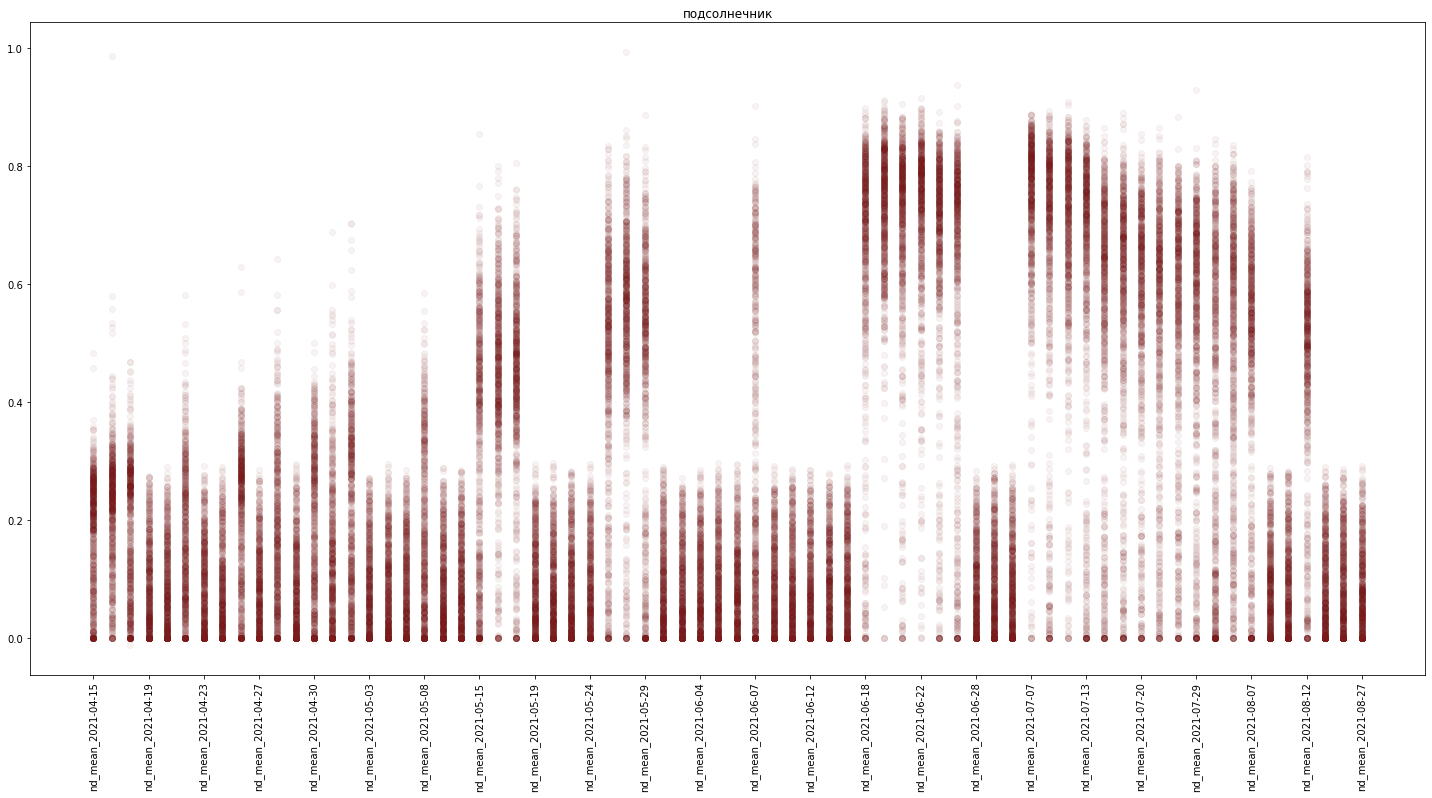

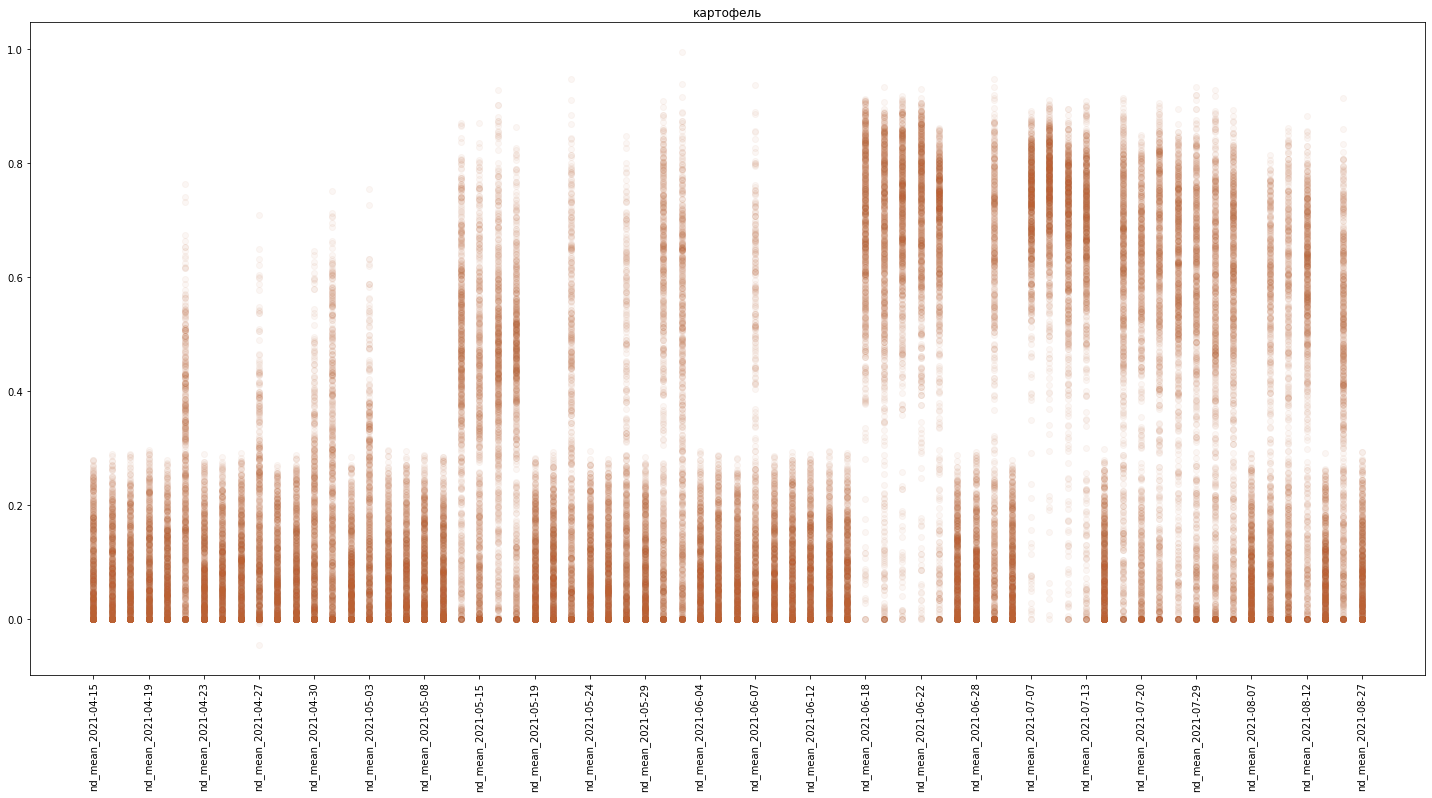

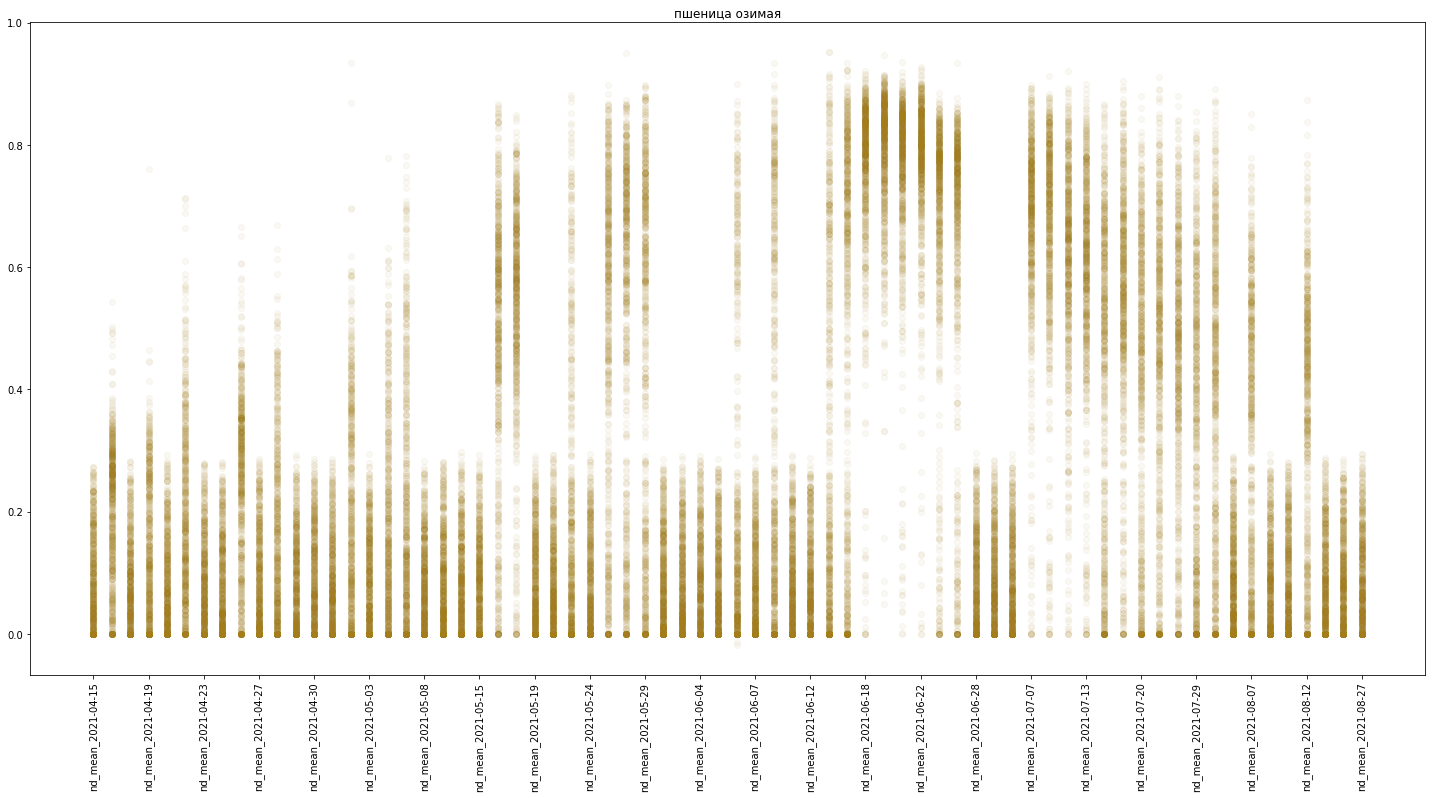

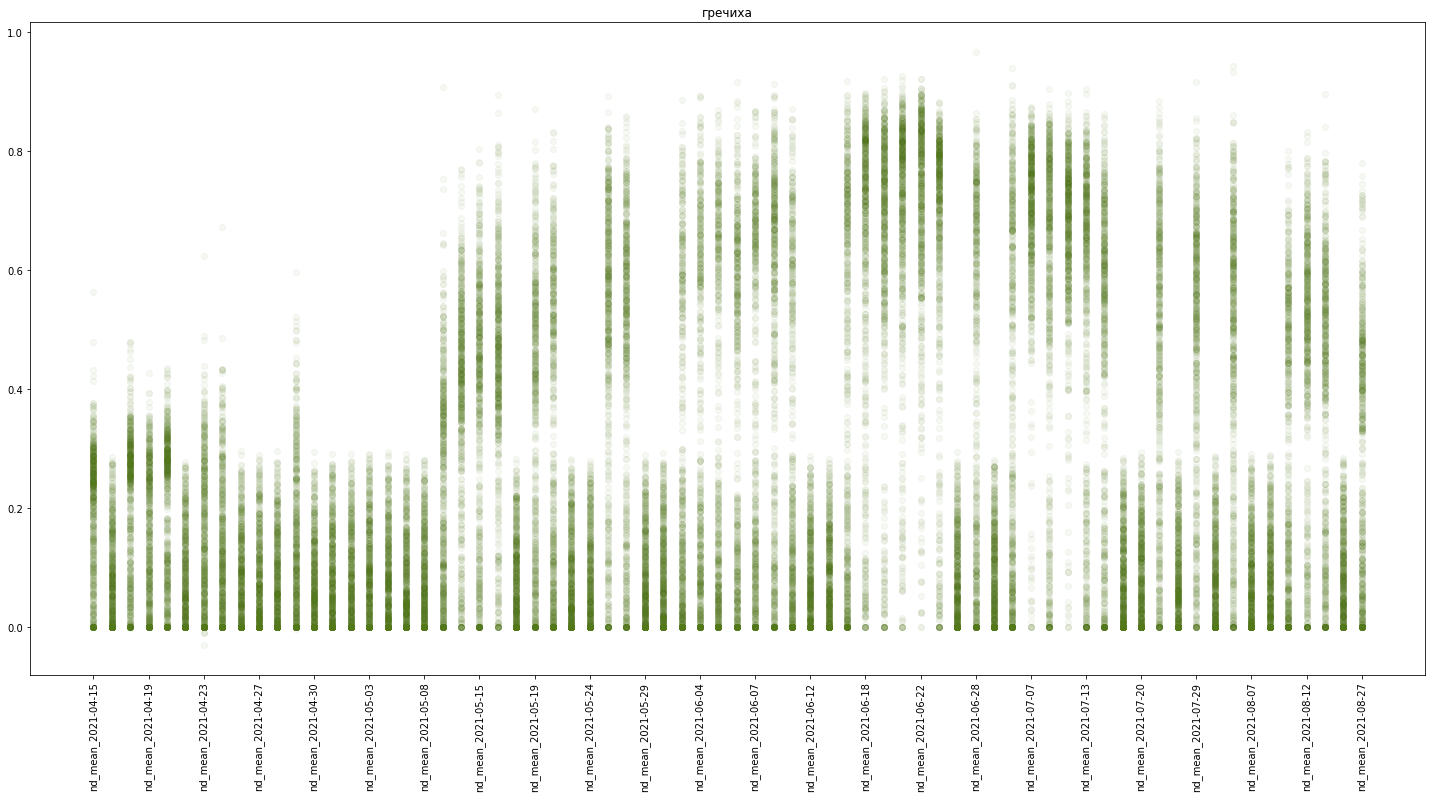

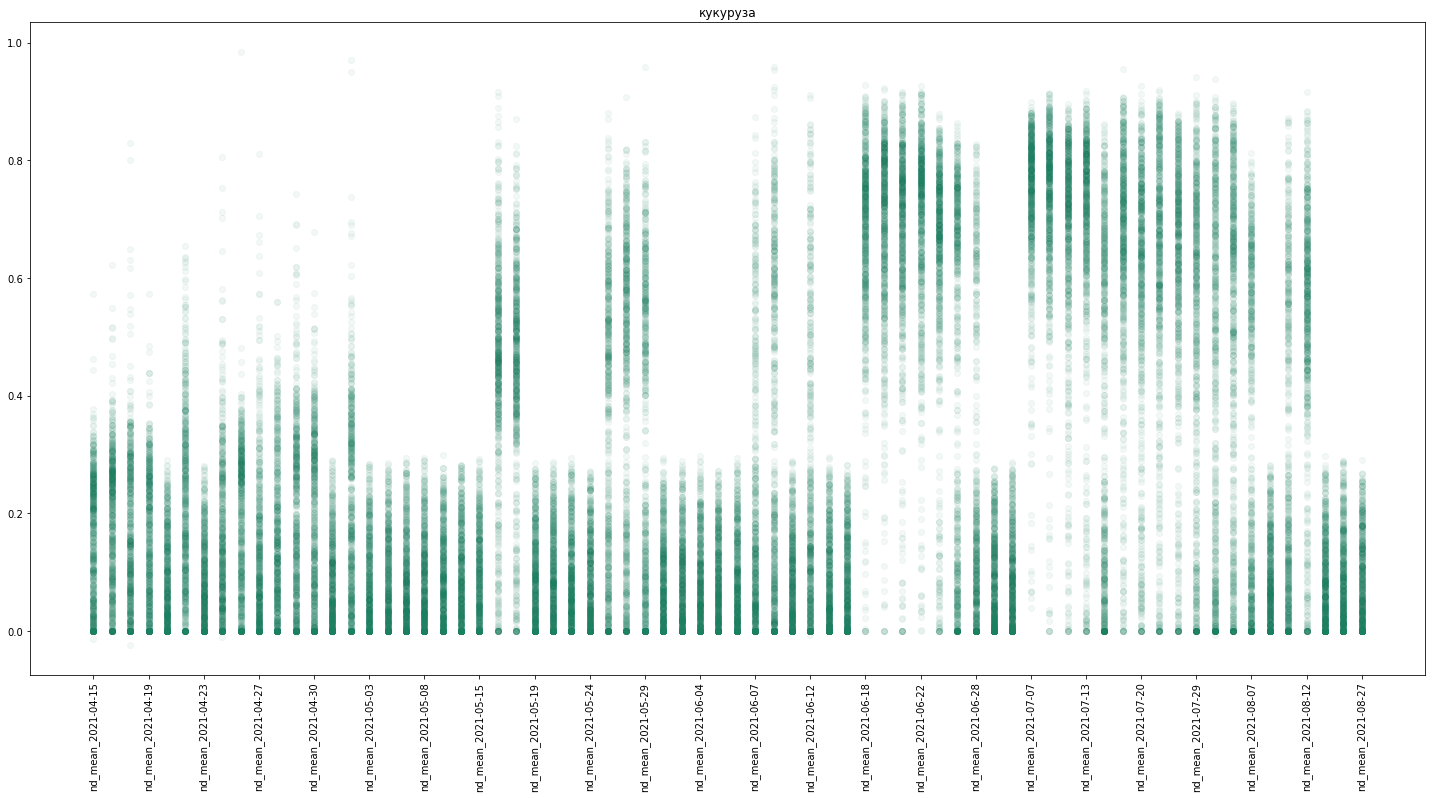

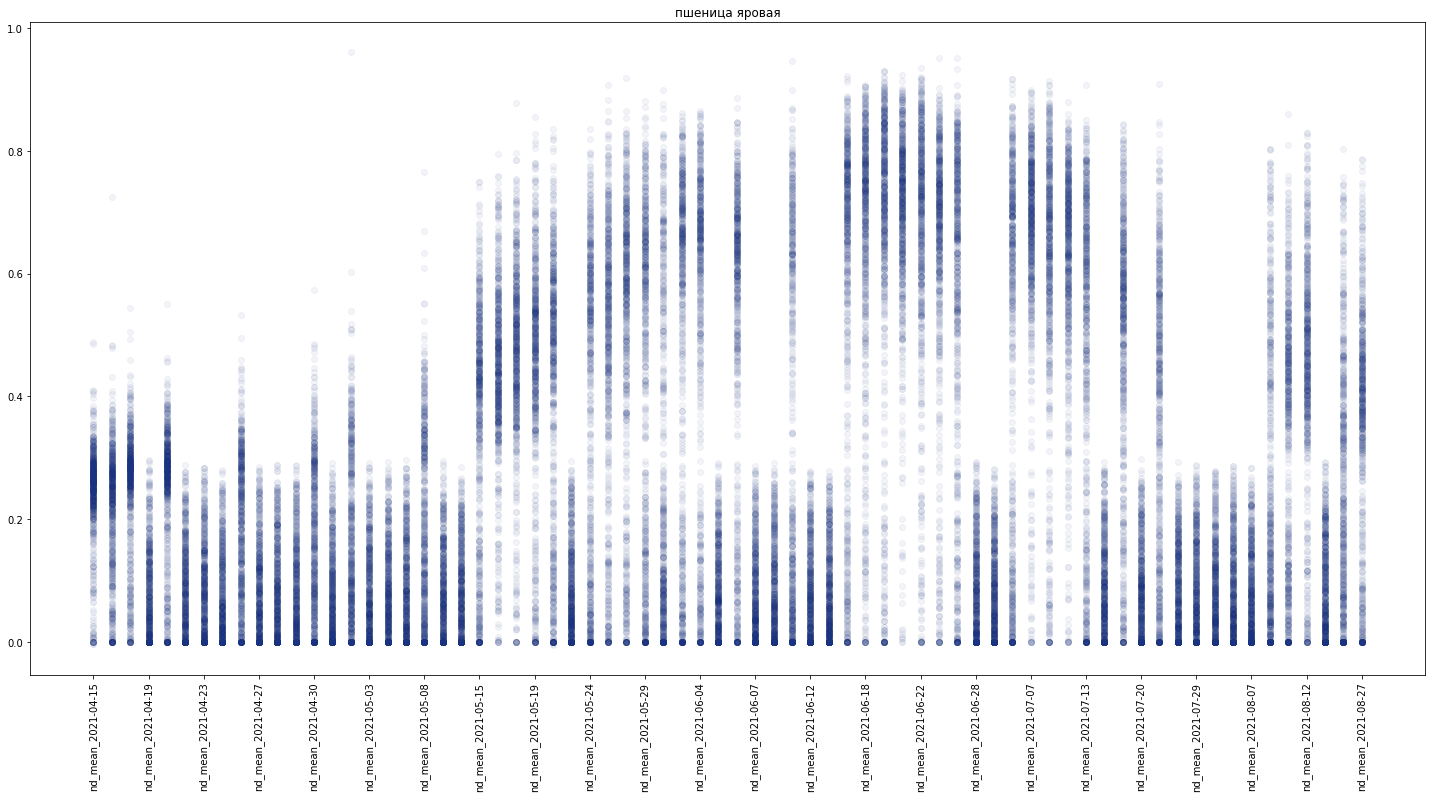

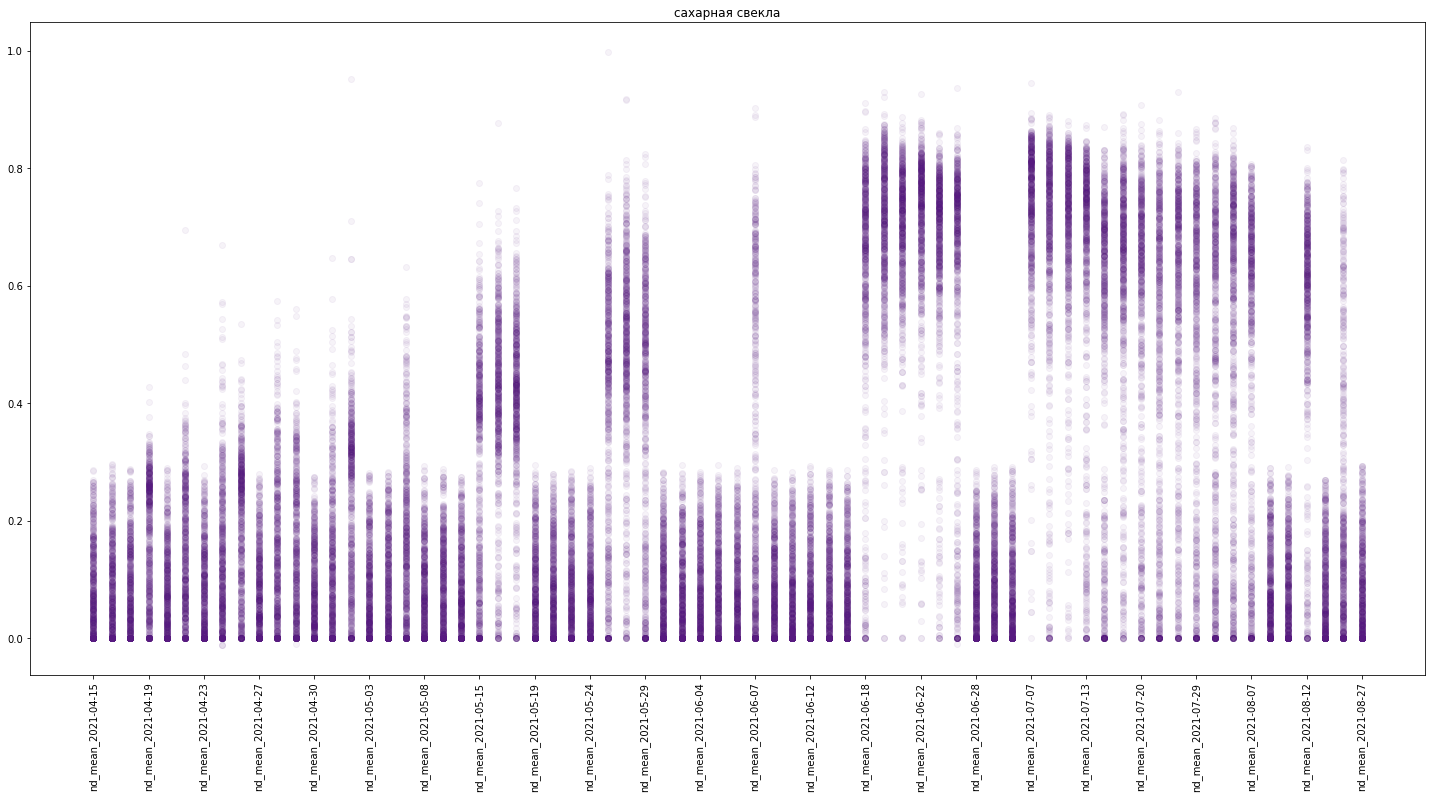

In [ ]:
ndvi_cols = [col for col in df_train.columns if 'nd_' in col]
for crop in crops_dict.keys():
    plt.figure(figsize=(25, 12))
    for s in df_train[ndvi_cols][df_train['crop'] == crop].to_numpy():
        plt.plot(ndvi_cols, s, color=colors[crop], marker='o', linewidth=0)
    
    # plt.plot(ndvi_cols, np.mean(df[ndvi_cols][df['crop'] == crop].to_numpy(), axis=0), color=colors[crop], label=crops_dict[crop])
    plt.xticks(np.arange(0, len(ndvi_cols), 3), labels=ndvi_cols[::3], rotation=90)
    plt.title(crops_dict[crop])
    plt.show()

In [ ]:
df_train.head()

area  crop    id  nd_mean_2021-04-15  nd_mean_2021-04-16  \
0    20     3  3536            0.187150            0.072846   
1    45     4  3739            0.245285            0.332928   
2    28     2  1294            0.006391            0.013679   
3    19     5  2859            0.293425            0.105976   
4    33     4  3685            0.027983            0.130885   

   nd_mean_2021-04-18  nd_mean_2021-04-19  nd_mean_2021-04-20  \
0            0.262300            0.261778            0.063134   
1            0.349133            0.287182            0.064671   
2            0.000000            0.007055            0.000000   
3            0.318047            0.052500            0.153700   
4            0.117227            0.063492            0.040565   

   nd_mean_2021-04-22  nd_mean_2021-04-23  ...  AVGH_13  AVGH_14  AVGH_15  \
0            0.062981            0.000000  ...        0        0        0   
1            0.097138            0.024539  ...        0        0        0   
2            0.120804            0.112471  ...        0        0        0   
3            0.001917            0.045054  ...        0        0        0   
4            0.024416            0.163886  ...        0        0        0   

   AVGH_16  AVGH_17  AVGH_18  AVGH_19  N_PEAKS  LONGEST  MAX_SRH  
0        0        0        0        0       11        5        0  
1        0        0        0        0       10        7        0  
2        0        0        0        0        9        7        0  
3        0        0        0        0       12        7        0  
4        0        0        0        0        5        7        0  

[5 rows x 161 columns]

Тепепрь рассмотрим главный столбец с C/Х культурой

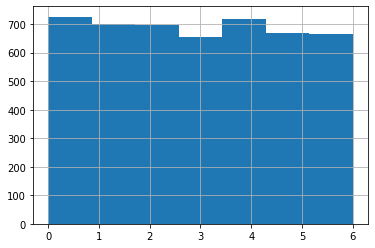

In [ ]:
df_train["crop"].hist(bins = 7)

In [ ]:
list(df_train.columns)

['area',
 'crop',
 'id',
 'nd_mean_2021-04-15',
 'nd_mean_2021-04-16',
 'nd_mean_2021-04-18',
 'nd_mean_2021-04-19',
 'nd_mean_2021-04-20',
 'nd_mean_2021-04-22',
 'nd_mean_2021-04-23',
 'nd_mean_2021-04-25',
 'nd_mean_2021-04-26',
 'nd_mean_2021-04-27',
 'nd_mean_2021-04-28',
 'nd_mean_2021-04-29',
 'nd_mean_2021-04-30',
 'nd_mean_2021-05-01',
 'nd_mean_2021-05-02',
 'nd_mean_2021-05-03',
 'nd_mean_2021-05-04',
 'nd_mean_2021-05-07',
 'nd_mean_2021-05-08',
 'nd_mean_2021-05-09',
 'nd_mean_2021-05-10',
 'nd_mean_2021-05-15',
 'nd_mean_2021-05-16',
 'nd_mean_2021-05-17',
 'nd_mean_2021-05-19',
 'nd_mean_2021-05-20',
 'nd_mean_2021-05-21',
 'nd_mean_2021-05-24',
 'nd_mean_2021-05-26',
 'nd_mean_2021-05-27',
 'nd_mean_2021-05-29',
 'nd_mean_2021-06-02',
 'nd_mean_2021-06-03',
 'nd_mean_2021-06-04',
 'nd_mean_2021-06-05',
 'nd_mean_2021-06-06',
 'nd_mean_2021-06-07',
 'nd_mean_2021-06-09',
 'nd_mean_2021-06-10',
 'nd_mean_2021-06-12',
 'nd_mean_2021-06-13',
 'nd_mean_2021-06-16',
 'nd_mean

## Выделим выборки

In [ ]:
X = df_train.drop(["crop", "id"], axis = 1)
y = df_train["crop"]

# col_info = dict()
# for col in X.columns:
#     col_info[col] = {'mean': np.mean(X[col]), 'std': np.std(X[col])}
#     X[col] = (X[col] - col_info[col]['mean']) / col_info[col]['std']

In [ ]:
X.head()

area  nd_mean_2021-04-15  nd_mean_2021-04-16  nd_mean_2021-04-18  \
0    20            0.187150            0.072846            0.262300   
1    45            0.245285            0.332928            0.349133   
2    28            0.006391            0.013679            0.000000   
3    19            0.293425            0.105976            0.318047   
4    33            0.027983            0.130885            0.117227   

   nd_mean_2021-04-19  nd_mean_2021-04-20  nd_mean_2021-04-22  \
0            0.261778            0.063134            0.062981   
1            0.287182            0.064671            0.097138   
2            0.007055            0.000000            0.120804   
3            0.052500            0.153700            0.001917   
4            0.063492            0.040565            0.024416   

   nd_mean_2021-04-23  nd_mean_2021-04-25  nd_mean_2021-04-26  ...  AVGH_13  \
0            0.000000            0.077577            0.104442  ...        0   
1            0.024539            0.173578            0.152467  ...        0   
2            0.112471            0.041751            0.037839  ...        0   
3            0.045054            0.072589            0.011531  ...        0   
4            0.163886            0.109385            0.000000  ...        0   

   AVGH_14  AVGH_15  AVGH_16  AVGH_17  AVGH_18  AVGH_19  N_PEAKS  LONGEST  \
0        0        0        0        0        0        0       11        5   
1        0        0        0        0        0        0       10        7   
2        0        0        0        0        0        0        9        7   
3        0        0        0        0        0        0       12        7   
4        0        0        0        0        0        0        5        7   

   MAX_SRH  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 159 columns]

In [ ]:
X.shape

(4830, 159)

## Обучение модели

In [ ]:
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7777)
scorer = make_scorer(recall_score, average='macro', zero_division = 0)

In [ ]:
# model = XGBClassifier()

In [ ]:
model = CatBoostClassifier(task_type="GPU", random_state=1, eval_metric='TotalF1')
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.120537
0:	learn: 0.7477058	test: 0.7204065	best: 0.7204065 (0)	total: 37.9ms	remaining: 37.9s
1:	learn: 0.7530572	test: 0.7319666	best: 0.7319666 (1)	total: 68.9ms	remaining: 34.4s
2:	learn: 0.7755691	test: 0.7675458	best: 0.7675458 (2)	total: 113ms	remaining: 37.7s
3:	learn: 0.7979866	test: 0.7820562	best: 0.7820562 (3)	total: 139ms	remaining: 34.6s
4:	learn: 0.8264026	test: 0.8073524	best: 0.8073524 (4)	total: 187ms	remaining: 37.2s
5:	learn: 0.8524935	test: 0.8344233	best: 0.8344233 (5)	total: 244ms	remaining: 40.5s
6:	learn: 0.8643276	test: 0.8440284	best: 0.8440284 (6)	total: 291ms	remaining: 41.3s
7:	learn: 0.8722677	test: 0.8518536	best: 0.8518536 (7)	total: 323ms	remaining: 40s
8:	learn: 0.8746145	test: 0.8589382	best: 0.8589382 (8)	total: 354ms	remaining: 39s
9:	learn: 0.8880470	test: 0.8782242	best: 0.8782242 (9)	total: 383ms	remaining: 37.9s
10:	learn: 0.8946486	test: 0.8824326	best: 0.8824326 (10)	total: 440ms	remaining: 39.5s
11:	learn: 0.8999382	tes

In [ ]:
predictions = model.predict(X_test)
score = recall_score(y_test, predictions, average='macro', zero_division = 0)
print(f'Default recall: {score}')

Default recall: 0.9681642108182905


In [ ]:
threshols = sorted(set(model.feature_importances_))[:-10]
threshols

[0.0,
 0.005344998796546162,
 0.011437268012036041,
 0.01159321073669343,
 0.011916349020383944,
 0.024403573085435032,
 0.025098246161786218,
 0.029278305015281704,
 0.03326075205913158,
 0.049792171216838446,
 0.05905851188273462,
 0.06750126211169045,
 0.0868405228493199,
 0.09131569858547683,
 0.09240774285540662,
 0.09328002946200012,
 0.09683088651873778,
 0.09732063645311065,
 0.10119134662829858,
 0.10703799050515538,
 0.11683500374051517,
 0.1232835670660733,
 0.12879987624728398,
 0.14312463953282198,
 0.15007406532179257,
 0.15302441559575689,
 0.1551532273194855,
 0.15630122888147033,
 0.15711461406050214,
 0.1709642656405988,
 0.1729308364819316,
 0.18429673240030825,
 0.19648048541286467,
 0.19713796585558002,
 0.19946789449194557,
 0.20254935171895216,
 0.20427984119295833,
 0.2070296403967501,
 0.2344500961327747,
 0.2406405834134796,
 0.24170464664029628,
 0.2507696246422889,
 0.26277288846135183,
 0.267120728323062,
 0.2823589640630591,
 0.2920480379039328,
 0.2922673

In [ ]:
for thre in tqdm(threshols):
    selection = SelectFromModel(model, threshold=thre, prefit=True)
    select_X_train = selection.transform(X_train)

    selection_model = CatBoostClassifier(task_type="GPU", random_state=1, verbose=0)
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    score = recall_score(y_test, predictions, average='macro', zero_division = 0)

    print()
    print('-' * 100)
    print(f'Threshold: {thre:.4f}, cols: {select_X_train.shape[1]}, recall: {score:.5f}')
    print('-' * 100)
    print()

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  1%|          | 1/98 [00:08<13:32,  8.38s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0000, cols: 159, recall: 0.96697
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  2%|▏         | 2/98 [00:16<13:19,  8.33s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0053, cols: 107, recall: 0.96697
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  3%|▎         | 3/98 [00:24<13:03,  8.25s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0114, cols: 106, recall: 0.96597
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  4%|▍         | 4/98 [00:33<12:58,  8.29s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0116, cols: 105, recall: 0.96388
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  5%|▌         | 5/98 [00:41<12:47,  8.25s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0119, cols: 104, recall: 0.96500
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  6%|▌         | 6/98 [00:49<12:38,  8.25s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0244, cols: 103, recall: 0.96721
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  7%|▋         | 7/98 [00:57<12:28,  8.22s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0251, cols: 102, recall: 0.96509
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  8%|▊         | 8/98 [01:05<12:19,  8.22s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0293, cols: 101, recall: 0.96491
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
  9%|▉         | 9/98 [01:14<12:09,  8.20s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0333, cols: 100, recall: 0.96382
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 10%|█         | 10/98 [01:22<12:00,  8.19s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0498, cols: 99, recall: 0.96713
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 11%|█         | 11/98 [01:30<11:51,  8.18s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0591, cols: 98, recall: 0.96713
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 12%|█▏        | 12/98 [01:38<11:41,  8.16s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0675, cols: 97, recall: 0.96825
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 13%|█▎        | 13/98 [01:46<11:32,  8.15s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0868, cols: 96, recall: 0.96718
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 14%|█▍        | 14/98 [01:54<11:24,  8.15s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0913, cols: 95, recall: 0.96709
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 15%|█▌        | 15/98 [02:02<11:16,  8.15s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0924, cols: 94, recall: 0.97038
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 16%|█▋        | 16/98 [02:11<11:29,  8.41s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0933, cols: 93, recall: 0.96934
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 17%|█▋        | 17/98 [02:20<11:13,  8.31s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0968, cols: 92, recall: 0.96573
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 18%|█▊        | 18/98 [02:28<10:59,  8.24s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.0973, cols: 91, recall: 0.96806
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 19%|█▉        | 19/98 [02:36<10:48,  8.21s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1012, cols: 90, recall: 0.96393
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 20%|██        | 20/98 [02:44<10:37,  8.17s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1070, cols: 89, recall: 0.96173
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 21%|██▏       | 21/98 [02:52<10:27,  8.15s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1168, cols: 88, recall: 0.96287
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 22%|██▏       | 22/98 [03:00<10:17,  8.13s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1233, cols: 87, recall: 0.95947
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 23%|██▎       | 23/98 [03:08<10:08,  8.12s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1288, cols: 86, recall: 0.96173
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 24%|██▍       | 24/98 [03:16<09:59,  8.10s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1431, cols: 85, recall: 0.96495
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 26%|██▌       | 25/98 [03:24<09:49,  8.07s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1501, cols: 84, recall: 0.96178
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 27%|██▋       | 26/98 [03:32<09:40,  8.06s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1530, cols: 83, recall: 0.96285
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 28%|██▊       | 27/98 [03:40<09:32,  8.06s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1552, cols: 82, recall: 0.96279
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 29%|██▊       | 28/98 [03:48<09:23,  8.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1563, cols: 81, recall: 0.96491
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 30%|██▉       | 29/98 [03:56<09:15,  8.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1571, cols: 80, recall: 0.96388
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 31%|███       | 30/98 [04:04<09:08,  8.06s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1710, cols: 79, recall: 0.96600
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 32%|███▏      | 31/98 [04:13<08:59,  8.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1729, cols: 78, recall: 0.96600
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 33%|███▎      | 32/98 [04:20<08:49,  8.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1843, cols: 77, recall: 0.96728
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 34%|███▎      | 33/98 [04:28<08:41,  8.02s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1965, cols: 76, recall: 0.96713
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 35%|███▍      | 34/98 [04:36<08:32,  8.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1971, cols: 75, recall: 0.96384
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 36%|███▌      | 35/98 [04:45<08:26,  8.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.1995, cols: 74, recall: 0.96718
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 37%|███▋      | 36/98 [04:53<08:18,  8.04s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2025, cols: 73, recall: 0.96375
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 38%|███▊      | 37/98 [05:01<08:10,  8.04s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2043, cols: 72, recall: 0.96406
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 39%|███▉      | 38/98 [05:09<08:03,  8.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2070, cols: 71, recall: 0.96604
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 40%|███▉      | 39/98 [05:18<08:25,  8.57s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2345, cols: 70, recall: 0.96418
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 41%|████      | 40/98 [05:27<08:07,  8.41s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2406, cols: 69, recall: 0.96102
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 42%|████▏     | 41/98 [05:35<07:53,  8.30s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2417, cols: 68, recall: 0.96327
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 43%|████▎     | 42/98 [05:43<07:40,  8.23s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2508, cols: 67, recall: 0.96303
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 44%|████▍     | 43/98 [05:51<07:29,  8.17s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2628, cols: 66, recall: 0.96100
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 45%|████▍     | 44/98 [05:59<07:17,  8.10s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2671, cols: 65, recall: 0.95994
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 46%|████▌     | 45/98 [06:07<07:07,  8.06s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2824, cols: 64, recall: 0.96094
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 47%|████▋     | 46/98 [06:15<06:57,  8.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2920, cols: 63, recall: 0.96203
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 48%|████▊     | 47/98 [06:22<06:48,  8.01s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.2923, cols: 62, recall: 0.96107
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 49%|████▉     | 48/98 [06:30<06:39,  8.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3041, cols: 61, recall: 0.96321
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 50%|█████     | 49/98 [06:38<06:30,  7.96s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3148, cols: 60, recall: 0.96404
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 51%|█████     | 50/98 [06:46<06:20,  7.93s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3203, cols: 59, recall: 0.95756
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 52%|█████▏    | 51/98 [06:54<06:12,  7.92s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3304, cols: 58, recall: 0.96081
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 53%|█████▎    | 52/98 [07:02<06:02,  7.89s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3366, cols: 57, recall: 0.96390
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 54%|█████▍    | 53/98 [07:10<05:53,  7.86s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3587, cols: 56, recall: 0.96290
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 55%|█████▌    | 54/98 [07:18<05:45,  7.86s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3629, cols: 55, recall: 0.96193
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 56%|█████▌    | 55/98 [07:25<05:37,  7.84s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3879, cols: 54, recall: 0.96062
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 57%|█████▋    | 56/98 [07:33<05:29,  7.86s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3936, cols: 53, recall: 0.96174
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 58%|█████▊    | 57/98 [07:41<05:22,  7.86s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.3986, cols: 52, recall: 0.96208
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 59%|█████▉    | 58/98 [07:49<05:14,  7.87s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4202, cols: 51, recall: 0.96202
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 60%|██████    | 59/98 [07:57<05:06,  7.86s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4248, cols: 50, recall: 0.96003
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 61%|██████    | 60/98 [08:05<04:57,  7.84s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4292, cols: 49, recall: 0.96509
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 62%|██████▏   | 61/98 [08:12<04:49,  7.83s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4298, cols: 48, recall: 0.96206
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 63%|██████▎   | 62/98 [08:22<04:56,  8.25s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4325, cols: 47, recall: 0.96321
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 64%|██████▍   | 63/98 [08:29<04:44,  8.12s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4493, cols: 46, recall: 0.96520
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 65%|██████▌   | 64/98 [08:37<04:31,  7.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4974, cols: 45, recall: 0.96436
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 66%|██████▋   | 65/98 [08:45<04:21,  7.92s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.4987, cols: 44, recall: 0.96624
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 67%|██████▋   | 66/98 [08:53<04:11,  7.84s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.5007, cols: 43, recall: 0.96199
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 68%|██████▊   | 67/98 [09:00<04:01,  7.79s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.5858, cols: 42, recall: 0.96205
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 69%|██████▉   | 68/98 [09:08<03:53,  7.77s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.5889, cols: 41, recall: 0.96077
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 70%|███████   | 69/98 [09:16<03:44,  7.74s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.5931, cols: 40, recall: 0.96096
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 71%|███████▏  | 70/98 [09:23<03:36,  7.74s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.6121, cols: 39, recall: 0.95868
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 72%|███████▏  | 71/98 [09:31<03:28,  7.73s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.6166, cols: 38, recall: 0.95777
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 73%|███████▎  | 72/98 [09:39<03:20,  7.70s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.6245, cols: 37, recall: 0.96412
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 74%|███████▍  | 73/98 [09:46<03:12,  7.70s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.7139, cols: 36, recall: 0.95837
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 76%|███████▌  | 74/98 [09:54<03:03,  7.66s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.7143, cols: 35, recall: 0.95644
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 77%|███████▋  | 75/98 [10:02<02:56,  7.66s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.7608, cols: 34, recall: 0.95533
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 78%|███████▊  | 76/98 [10:09<02:48,  7.65s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.8125, cols: 33, recall: 0.95544
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 79%|███████▊  | 77/98 [10:17<02:41,  7.67s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.8644, cols: 32, recall: 0.95730
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 80%|███████▉  | 78/98 [10:25<02:33,  7.66s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 0.9154, cols: 31, recall: 0.95661
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 81%|████████  | 79/98 [10:32<02:25,  7.65s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.0881, cols: 30, recall: 0.95231
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 82%|████████▏ | 80/98 [10:40<02:17,  7.63s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.1241, cols: 29, recall: 0.95462
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 83%|████████▎ | 81/98 [10:47<02:09,  7.62s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.1331, cols: 28, recall: 0.95231
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 84%|████████▎ | 82/98 [10:55<02:01,  7.59s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.1797, cols: 27, recall: 0.95358
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 85%|████████▍ | 83/98 [11:03<01:53,  7.59s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.2317, cols: 26, recall: 0.95330
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 86%|████████▌ | 84/98 [11:10<01:46,  7.57s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.3263, cols: 25, recall: 0.95029
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 87%|████████▋ | 85/98 [11:18<01:38,  7.58s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.3311, cols: 24, recall: 0.95006
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 88%|████████▊ | 86/98 [11:27<01:38,  8.22s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.4287, cols: 23, recall: 0.95006
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 89%|████████▉ | 87/98 [11:35<01:28,  8.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.5498, cols: 22, recall: 0.94457
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 90%|████████▉ | 88/98 [11:42<01:18,  7.85s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.5810, cols: 21, recall: 0.93610
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 91%|█████████ | 89/98 [11:50<01:09,  7.75s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.6800, cols: 20, recall: 0.93704
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 92%|█████████▏| 90/98 [11:57<01:01,  7.68s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.7170, cols: 19, recall: 0.92479
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 93%|█████████▎| 91/98 [12:05<00:53,  7.62s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.7656, cols: 18, recall: 0.91164
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 94%|█████████▍| 92/98 [12:12<00:45,  7.55s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.7767, cols: 17, recall: 0.90550
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 95%|█████████▍| 93/98 [12:20<00:37,  7.52s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 1.8294, cols: 16, recall: 0.90538
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 96%|█████████▌| 94/98 [12:27<00:30,  7.50s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 2.0156, cols: 15, recall: 0.90459
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 97%|█████████▋| 95/98 [12:34<00:22,  7.44s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 2.4379, cols: 14, recall: 0.89426
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 98%|█████████▊| 96/98 [12:42<00:14,  7.40s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 2.6041, cols: 13, recall: 0.87840
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
 99%|█████████▉| 97/98 [12:49<00:07,  7.38s/it]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"



----------------------------------------------------------------------------------------------------
Threshold: 2.6043, cols: 12, recall: 0.86015
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
100%|██████████| 98/98 [12:56<00:00,  7.93s/it]


----------------------------------------------------------------------------------------------------
Threshold: 3.0416, cols: 11, recall: 0.85138
----------------------------------------------------------------------------------------------------



In [ ]:
[col for col, imp in zip(X.columns, model.feature_importances_) if imp > 0.0923] # 0.971 recall

['area',
 'nd_mean_2021-04-15',
 'nd_mean_2021-04-16',
 'nd_mean_2021-04-18',
 'nd_mean_2021-04-19',
 'nd_mean_2021-04-20',
 'nd_mean_2021-04-22',
 'nd_mean_2021-04-23',
 'nd_mean_2021-04-25',
 'nd_mean_2021-04-26',
 'nd_mean_2021-04-27',
 'nd_mean_2021-04-28',
 'nd_mean_2021-04-29',
 'nd_mean_2021-04-30',
 'nd_mean_2021-05-01',
 'nd_mean_2021-05-02',
 'nd_mean_2021-05-03',
 'nd_mean_2021-05-04',
 'nd_mean_2021-05-07',
 'nd_mean_2021-05-08',
 'nd_mean_2021-05-10',
 'nd_mean_2021-05-15',
 'nd_mean_2021-05-16',
 'nd_mean_2021-05-17',
 'nd_mean_2021-05-19',
 'nd_mean_2021-05-20',
 'nd_mean_2021-05-21',
 'nd_mean_2021-05-24',
 'nd_mean_2021-05-26',
 'nd_mean_2021-05-27',
 'nd_mean_2021-05-29',
 'nd_mean_2021-06-02',
 'nd_mean_2021-06-03',
 'nd_mean_2021-06-04',
 'nd_mean_2021-06-05',
 'nd_mean_2021-06-06',
 'nd_mean_2021-06-07',
 'nd_mean_2021-06-09',
 'nd_mean_2021-06-10',
 'nd_mean_2021-06-12',
 'nd_mean_2021-06-13',
 'nd_mean_2021-06-16',
 'nd_mean_2021-06-18',
 'nd_mean_2021-06-19',
 '

In [ ]:
important_features = ['area',
 'nd_mean_2021-04-15',
 'nd_mean_2021-04-16',
 'nd_mean_2021-04-18',
 'nd_mean_2021-04-19',
 'nd_mean_2021-04-20',
 'nd_mean_2021-04-22',
 'nd_mean_2021-04-23',
 'nd_mean_2021-04-25',
 'nd_mean_2021-04-26',
 'nd_mean_2021-04-27',
 'nd_mean_2021-04-28',
 'nd_mean_2021-04-29',
 'nd_mean_2021-04-30',
 'nd_mean_2021-05-01',
 'nd_mean_2021-05-02',
 'nd_mean_2021-05-03',
 'nd_mean_2021-05-04',
 'nd_mean_2021-05-07',
 'nd_mean_2021-05-08',
 'nd_mean_2021-05-10',
 'nd_mean_2021-05-15',
 'nd_mean_2021-05-16',
 'nd_mean_2021-05-17',
 'nd_mean_2021-05-19',
 'nd_mean_2021-05-20',
 'nd_mean_2021-05-21',
 'nd_mean_2021-05-24',
 'nd_mean_2021-05-26',
 'nd_mean_2021-05-27',
 'nd_mean_2021-05-29',
 'nd_mean_2021-06-02',
 'nd_mean_2021-06-03',
 'nd_mean_2021-06-04',
 'nd_mean_2021-06-05',
 'nd_mean_2021-06-06',
 'nd_mean_2021-06-07',
 'nd_mean_2021-06-09',
 'nd_mean_2021-06-10',
 'nd_mean_2021-06-12',
 'nd_mean_2021-06-13',
 'nd_mean_2021-06-16',
 'nd_mean_2021-06-18',
 'nd_mean_2021-06-19',
 'nd_mean_2021-06-20',
 'nd_mean_2021-06-22',
 'nd_mean_2021-06-25',
 'nd_mean_2021-06-27',
 'nd_mean_2021-06-28',
 'nd_mean_2021-07-04',
 'nd_mean_2021-07-05',
 'nd_mean_2021-07-07',
 'nd_mean_2021-07-08',
 'nd_mean_2021-07-09',
 'nd_mean_2021-07-13',
 'nd_mean_2021-07-15',
 'nd_mean_2021-07-17',
 'nd_mean_2021-07-20',
 'nd_mean_2021-07-26',
 'nd_mean_2021-07-27',
 'nd_mean_2021-07-29',
 'nd_mean_2021-07-31',
 'nd_mean_2021-08-01',
 'nd_mean_2021-08-07',
 'nd_mean_2021-08-10',
 'nd_mean_2021-08-11',
 'nd_mean_2021-08-12',
 'nd_mean_2021-08-13',
 'nd_mean_2021-08-23',
 'nd_mean_2021-08-27',
 'coord_1',
 'coord_2',
 'TOTAL_LOW_VALUES',
 'LOW_6_6',
 'LOW_6_21',
 'LOW_6_24',
 'LOW_6_30',
 'LOW_6_33',
 'LOW_6_36',
 'LOW_6_42',
 'LOW_6_45',
 'LOW_6_54',
 'LOW_6_60',
 'LOW_6_63',
 'LOW_6_66',
 'LOW_6_69',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'N_PEAKS',
 'LONGEST']

In [ ]:
model = CatBoostClassifier(task_type="GPU", random_state=1, verbose=0)
rcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

scores = cross_val_score(model, X[important_features], y, cv=rcv, scoring=scorer)
print(f'Cross validation mean={np.mean(scores)}, std={np.std(scores)}, range=({np.min(scores), np.max(scores)})')

Cross validation mean=0.9670215197749544, std=0.004871626687225045, range=((0.9542129701442715, 0.9784867850006821))


In [ ]:
model = CatBoostClassifier(iterations=3300,
                           boosting_type='Plain',
                        #    bootstrap_type='Poisson',
                           depth=10,
                           grow_policy='Lossguide',
                           l2_leaf_reg=2.0,
                        #    leaf_estimation_backtracking='Armijo',
                           loss_function='MultiClass',
                           task_type="GPU",
                           random_state=5,
                           od_wait=100)

model.fit(X_train[important_features], y_train, eval_set=(X_test[important_features], y_test))

0:	learn: 1.8197619	test: 1.8210271	best: 1.8210271 (0)	total: 54.7ms	remaining: 3m
1:	learn: 1.7137560	test: 1.7183289	best: 1.7183289 (1)	total: 102ms	remaining: 2m 48s
2:	learn: 1.6210864	test: 1.6275057	best: 1.6275057 (2)	total: 149ms	remaining: 2m 43s
3:	learn: 1.5389835	test: 1.5459788	best: 1.5459788 (3)	total: 195ms	remaining: 2m 40s
4:	learn: 1.4671875	test: 1.4761633	best: 1.4761633 (4)	total: 240ms	remaining: 2m 38s
5:	learn: 1.4025922	test: 1.4130585	best: 1.4130585 (5)	total: 291ms	remaining: 2m 39s
6:	learn: 1.3432764	test: 1.3550299	best: 1.3550299 (6)	total: 329ms	remaining: 2m 34s
7:	learn: 1.2886608	test: 1.3021434	best: 1.3021434 (7)	total: 353ms	remaining: 2m 25s
8:	learn: 1.2381171	test: 1.2525060	best: 1.2525060 (8)	total: 378ms	remaining: 2m 18s
9:	learn: 1.1904753	test: 1.2070968	best: 1.2070968 (9)	total: 402ms	remaining: 2m 12s
10:	learn: 1.1467688	test: 1.1644448	best: 1.1644448 (10)	total: 427ms	remaining: 2m 7s
11:	learn: 1.1067247	test: 1.1251458	best: 1.

## Оценка точности

In [ ]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

pred = model.predict(X_test[important_features])
print(model,'\n',recall_score(y_test, pred, average="macro", zero_division=0))

 0.9717750729239752


In [ ]:
models = [
        CatBoostClassifier(iterations=2500,
                           boosting_type='Plain',
                           depth=10,
                           grow_policy='Lossguide',
                           l2_leaf_reg=2.0,
                           loss_function='MultiClass',
                           task_type="GPU",
                           random_state=5),
          CatBoostClassifier(iterations=2500,
                           boosting_type='Plain',
                           depth=10,
                           grow_policy='Lossguide',
                           l2_leaf_reg=2.0,
                           loss_function='MultiClass',
                           task_type="GPU",
                           random_state=7),
          CatBoostClassifier(iterations=2500,
                           boosting_type='Plain',
                           depth=10,
                           grow_policy='Lossguide',
                           l2_leaf_reg=2.0,
                           loss_function='MultiClass',
                           task_type="GPU",
                           random_state=66),
          CatBoostClassifier(iterations=2500,
                           boosting_type='Plain',
                           depth=10,
                           grow_policy='Lossguide',
                           l2_leaf_reg=2.0,
                           loss_function='MultiClass',
                           task_type="GPU",
                           random_state=42),
          CatBoostClassifier(iterations=2500,
                           boosting_type='Plain',
                           depth=10,
                           grow_policy='Lossguide',
                           l2_leaf_reg=2.0,
                           loss_function='MultiClass',
                           task_type="GPU",
                           random_state=123)
    ]

In [ ]:
for model in models:
    model.fit(X[important_features], y)

Streaming output truncated to the last 5000 lines.
0:	learn: 1.8181825	total: 18ms	remaining: 44.9s
1:	learn: 1.7103261	total: 35.6ms	remaining: 44.4s
2:	learn: 1.6167950	total: 52.2ms	remaining: 43.4s
3:	learn: 1.5337108	total: 67.9ms	remaining: 42.4s
4:	learn: 1.4603842	total: 84.2ms	remaining: 42s
5:	learn: 1.3946098	total: 100ms	remaining: 41.7s
6:	learn: 1.3341881	total: 116ms	remaining: 41.4s
7:	learn: 1.2791121	total: 132ms	remaining: 41.3s
8:	learn: 1.2292707	total: 151ms	remaining: 41.8s
9:	learn: 1.1817961	total: 167ms	remaining: 41.5s
10:	learn: 1.1378144	total: 183ms	remaining: 41.5s
11:	learn: 1.0976823	total: 222ms	remaining: 46s
12:	learn: 1.0598107	total: 248ms	remaining: 47.4s
13:	learn: 1.0244928	total: 263ms	remaining: 46.8s
14:	learn: 0.9916924	total: 279ms	remaining: 46.3s
15:	learn: 0.9608925	total: 296ms	remaining: 45.9s
16:	learn: 0.9318518	total: 312ms	remaining: 45.5s
17:	learn: 0.9024614	total: 328ms	remaining: 45.3s
18:	learn: 0.8762028	total: 345ms	remainin

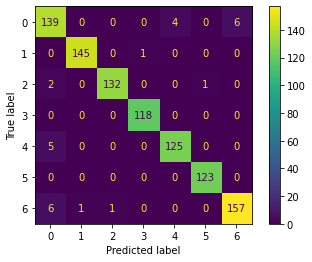

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()

In [ ]:
mistakes = X_test[pred[:, 0] != y_test]

In [ ]:
len(mistakes)

23

In [ ]:
test_data = prepare_dataset(pd.read_csv("/content/test_dataset_test.csv"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
X_leaderboard = test_data.drop(["id"], axis = 1)

In [ ]:
X_leaderboard.head()

area  nd_mean_2021-04-15  nd_mean_2021-04-16  nd_mean_2021-04-18  \
0    26            0.083038            0.196691            0.244827   
1    98            0.122470            0.091192            0.241003   
2    21            0.259347            0.000000            0.297489   
3    18            0.166209            0.111243            0.000000   
4    53            0.010862            0.000000            0.067479   

   nd_mean_2021-04-19  nd_mean_2021-04-20  nd_mean_2021-04-22  \
0            0.000000            0.241219            0.259303   
1            0.000000            0.181600            0.125823   
2            0.033368            0.000000            0.285057   
3            0.201012            0.083885            0.000000   
4            0.234954            0.000000            0.000000   

   nd_mean_2021-04-23  nd_mean_2021-04-25  nd_mean_2021-04-26  ...      CS_60  \
0            0.064947            0.066446            0.052522  ...  17.154945   
1            0.108175            0.081871            0.000000  ...  18.876171   
2            0.374026            0.000000            0.028275  ...  16.417720   
3            0.015033            0.065305            0.000000  ...  14.636423   
4            0.000000            0.103583            0.305964  ...  14.316180   

       CS_61      CS_62      CS_63      CS_64      CS_65      CS_66  \
0  17.154945  17.748856  17.748856  17.748856  17.940872  18.105712   
1  19.205974  19.205974  19.213402  19.213402  19.319886  19.487364   
2  16.417720  16.966848  16.966848  16.992989  17.462341  17.939722   
3  15.234297  15.916220  15.951936  16.645781  17.260452  17.894738   
4  14.450315  15.230620  15.260844  15.307738  15.307738  16.086928   

       CS_67      CS_68      CS_69  
0  18.820004  18.885034  18.969230  
1  19.487364  19.487364  19.596310  
2  17.977560  17.977560  18.135839  
3  18.003728  18.536675  18.774416  
4  16.135551  16.786292  16.907588  

[5 rows x 296 columns]

In [ ]:
preds = np.zeros(shape=(len(X_leaderboard), 7))
for model in models:
    preds += model.predict_proba(X_leaderboard[important_features])

preds = np.argmax(preds, axis=1)

In [ ]:
submission = pd.read_csv("/content/sample_solution.csv")
submission["crop"] = preds

In [ ]:
submission.to_csv("/content/solution.csv", index=False)